### CITS4404 Practical Project

# Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).

In [1313]:
# Imports

import numpy as np
import imageio.v3 as iio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images


In [1314]:
# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


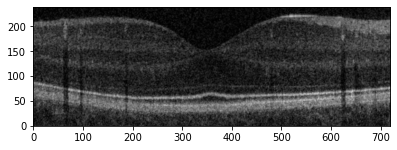

In [1315]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [1316]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = intermediate_points(self)
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        colours = [image[point[0],point[1]] for point in intermediates]
        return(np.array(colours)/255)


In [1317]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()


In [1318]:
# Example of a random worm. You may do this differently.

    # centre points, angles and colour chosen from uniform distributions
    # lengths chosen from normal distributions with two std parameters passed
    # width chosen from gamma distribution with shape parameter 3 and scale passed

def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)


In [1319]:
# Initialise a random clew

def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
    return clew

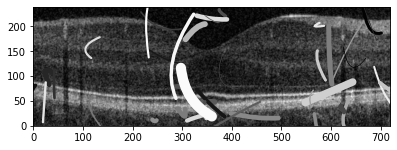

In [1320]:
# Initialise clew of 40 and draw

clew = initialise_clew(40, image.shape, (40, 30, 1))
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.show()

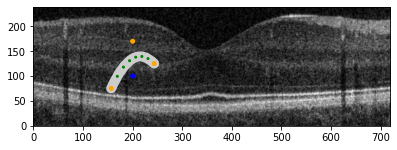

In [1321]:
# Draw a single worm along with control points and some sample points

worm = Camo_Worm(200, 100, 50, np.pi/6, 70, np.pi/3, 10, 0.8)
drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.intermediate_points(8), radius=2, color='green')
drawing.add_dots(worm.control_points(),color='orange')
drawing.add_dots((200,100), color='blue')

drawing.show(save='bezier.png')

&copy; Cara MacNish, UWA, 2024

# Quadratic approximation of worms

In [1322]:
# Initialise clew
clew = initialise_clew(5, image.shape, (40, 30, 1))

In [1323]:
points = clew[1].intermediate_points()


Quadratic function approximation: f(x) = 13.93x^2 + -14983.61x + 4027959.55


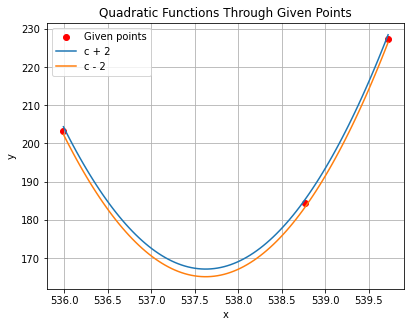

In [1324]:
import numpy as np
import matplotlib.pyplot as plt

def quadratic_approximation(control_points, degree = 2):
    # Unpack the control points
    x_values = np.array([point[0] for point in control_points])
    y_values = np.array([point[1] for point in control_points])
    
    # Set up the matrix equations
    A = np.vander(x_values, degree + 1)  # Vandermonde matrix for polynomial of degree `degree`
    coefficients = np.linalg.lstsq(A, y_values, rcond=None)[0]
    
    return coefficients
    
def plot_quadratic_function(a, b, c, points, ax, label=None):
    # Generate x values for plotting
    x_values = np.linspace(min([point[0] for point in points]), max([point[0] for point in points]), 100)
    
    # Calculate corresponding y values using the quadratic function
    y_values = a * x_values**2 + b * x_values + c
    
    # Plot the quadratic function
    ax.plot(x_values, y_values, label=label)



# Get coefficients for the quadratic function approximation
a, b, c = quadratic_approximation(points)

# Print the coefficients
print("Quadratic function approximation: f(x) = {:.2f}x^2 + {:.2f}x + {:.2f}".format(a, b, c))

# Create a figure and axis for the subplots
fig, ax = plt.subplots()

# Plot the original points
ax.scatter([point[0] for point in points], [point[1] for point in points], color='red', label='Given points')

# Plot the quadratic functions with adjusted c values
plot_quadratic_function(a, b, c + clew[1].width//2, points, ax, label='c + 2')
plot_quadratic_function(a, b, c - clew[1].width//2, points, ax, label='c - 2')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Quadratic Functions Through Given Points')
ax.legend()
ax.grid(True)

plt.show()


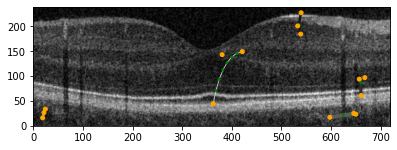

In [1325]:
drawing = Drawing(image)
drawing.add_worms(clew)

for worm in clew:
    drawing.add_dots(worm.intermediate_points(), radius=2, color='green')
    drawing.add_dots(worm.control_points(),color='orange')
drawing.show()

In [1326]:
import numpy as np
from sklearn.cluster import KMeans

def calculate_kmeans_inertia(points, num_clusters):
    # Convert points to NumPy array
    points_array = np.array(points)
    
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(points_array)
    
    # Calculate inertia
    inertia = kmeans.inertia_
    
    return inertia

# Assuming `clew` is an object or variable containing a single clew,
# and each clew has a method `intermediate_points()` to retrieve its points

# Initialize a list to store inertia values for each worm within the clew
worm_inertia_values = []

# Initialize a list to store intermediate points for all worms within the clew
all_worm_points = []

# Iterate over all worms in the clew
for worm in clew:
    # Get points for the current worm
    worm_points = worm.intermediate_points()
    
    # Extend the list of all worm points with the points of the current worm
    all_worm_points.extend(worm_points)

# Calculate the number of worms (clusters) within the clew
num_worms = len(clew)

# Calculate k-means inertia for the entire clew (all worms)
inertia = calculate_kmeans_inertia(all_worm_points, num_worms)

# Print the inertia value for the entire clew
print(f"Clew K-means inertia: {inertia}")


Clew K-means inertia: 15325.582626869727


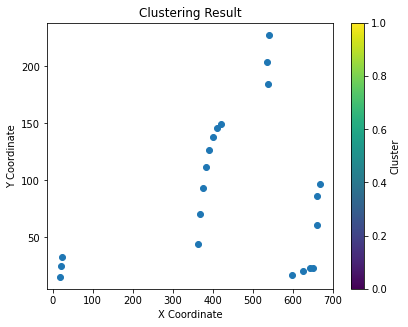

In [1327]:
import matplotlib.pyplot as plt

# Assuming `labels` contains the cluster assignments for each point
# Plot the intermediate points of the clew
plt.scatter([point[0] for point in all_worm_points], [point[1] for point in all_worm_points])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Clustering Result')
plt.colorbar(label='Cluster')
plt.show()


In [1328]:
all_worm_points = [worm.intermediate_points() for worm in clew]

In [1329]:
all_worm_points

[(array([362.47295848,  44.03540353]),
  array([368.05282806,  70.3975988 ]),
  array([374.56285171,  92.97160237]),
  array([382.00302941, 111.75741423]),
  array([390.37336117, 126.75503438]),
  array([399.67384699, 137.96446283]),
  array([409.90448686, 145.38569957]),
  array([421.0652808, 149.0187446])),
 (array([538.7724355, 184.4144711]),
  array([535.99166261, 203.36873711]),
  array([539.72433907, 227.4390875 ])),
 (array([660.87392384,  60.55040896]),
  array([660.67157895,  86.10973505]),
  array([668.08141561,  96.54931491])),
 (array([18.5812466 , 15.52533201]),
  array([21.20821087, 25.21633564]),
  array([23.99311625, 33.08665214])),
 (array([597.62799817,  16.63079419]),
  array([624.86851481,  20.83727731]),
  array([642.35931613,  22.93730892]),
  array([650.10040216,  22.93088902]))]

In [1330]:
def box_worm_into_rectangle(worm_points):
    min_x = min(point[0] for point in worm_points)
    max_x = max(point[0] for point in worm_points)
    min_y = min(point[1] for point in worm_points)
    max_y = max(point[1] for point in worm_points)
    return [min_x, min_y, max_x, max_y]

In [1331]:
rectangle_clew = [box_worm_into_rectangle(worm_points) for worm_points in all_worm_points]

In [1332]:
rectangle_clew

[[362.4729584765277, 44.03540352537896, 421.0652807979861, 149.0187445989445],
 [535.9916626149144,
  184.41447110087915,
  539.7243390721761,
  227.43908750281446],
 [660.6715789470858, 60.550408961941784, 668.0814156070878, 96.54931491430251],
 [18.581246599372708,
  15.525332012004908,
  23.99311625262032,
  33.08665213538531],
 [597.6279981727728, 16.630794187411542, 650.1004021569765, 22.93730891691105]]

In [1333]:
import numpy as np

def distance_between_rectangles(rect1, rect2):
    # Calculate the center of each rectangle
    center1 = np.array([(rect1[0] + rect1[2]) / 2, (rect1[1] + rect1[3]) / 2])
    center2 = np.array([(rect2[0] + rect2[2]) / 2, (rect2[1] + rect2[3]) / 2])
    
    # Calculate the Euclidean distance between the centers
    distance = np.linalg.norm(center1 - center2)
    return distance

def max_distance_between_rectangles(rectangles):
    max_distance = 0
    num_rectangles = len(rectangles)
    
    # Iterate through all pairs of rectangles
    for i in range(num_rectangles):
        for j in range(i + 1, num_rectangles):
            distance = distance_between_rectangles(rectangles[i], rectangles[j])
            max_distance = max(max_distance, distance)
    
    return max_distance

# Example usage
rectangles = rectangle_clew

max_dist = max_distance_between_rectangles(rectangles)
print("Maximum distance between rectangles:", max_dist)


Maximum distance between rectangles: 645.3729662603573


In [1334]:
import numpy as np

def center_of_mass(rectangles):
    centers = np.array([(rect[0] + rect[2]) / 2 for rect in rectangles]), np.array([(rect[1] + rect[3]) / 2 for rect in rectangles])
    return np.mean(centers, axis=1)

def move_rectangles(rectangles, step_size=0.1, max_iterations=1000, tolerance=1e-6, inertia=0.9):
    num_rectangles = len(rectangles)
    prev_inertia = float('inf')
    
    # Initialize velocities for each rectangle
    velocities = np.zeros((num_rectangles, 2))
    
    for iteration in range(max_iterations):
        # Compute the current center of mass and inertia
        com = center_of_mass(rectangles)
        curr_inertia = np.sum(np.linalg.norm(com - [(rect[0] + rect[2]) / 2, (rect[1] + rect[3]) / 2]) ** 2 for rect in rectangles)
        
        # Check for convergence
        if abs(curr_inertia - prev_inertia) < tolerance:
            print("Converged at iteration:", iteration)
            break
        
        # Update the previous inertia
        prev_inertia = curr_inertia
        
        # Move each rectangle slightly to minimize the inertia
        for i in range(num_rectangles):
            # Calculate the direction vector towards the center of mass
            direction = com - np.array([(rectangles[i][0] + rectangles[i][2]) / 2, (rectangles[i][1] + rectangles[i][3]) / 2])
            
            # Normalize the direction vector
            direction /= np.linalg.norm(direction) if np.linalg.norm(direction) != 0 else 1
            
            # Update velocity based on direction and inertia
            velocities[i] = inertia * velocities[i] + step_size * direction
            print("Velocity for rectangle", i, ":", velocities[i])
            
            # Move rectangle i based on velocity
            rectangles[i][0] += velocities[i][0]
            rectangles[i][1] += velocities[i][1]
            rectangles[i][2] += velocities[i][0]
            rectangles[i][3] += velocities[i][1]
    
    return rectangles

# Example usage
# rectangles = [rect1, rect2, ...]  # List of rectangles
# rectangles = move_rectangles(rectangles)

# After running move_rectangles, rectangles will contain the moved positions of the rectangles


In [1335]:
rectangle_clew

[[362.4729584765277, 44.03540352537896, 421.0652807979861, 149.0187445989445],
 [535.9916626149144,
  184.41447110087915,
  539.7243390721761,
  227.43908750281446],
 [660.6715789470858, 60.550408961941784, 668.0814156070878, 96.54931491430251],
 [18.581246599372708,
  15.525332012004908,
  23.99311625262032,
  33.08665213538531],
 [597.6279981727728, 16.630794187411542, 650.1004021569765, 22.93730891691105]]

In [1336]:
new_rectangles = move_rectangles(rectangle_clew, step_size=0.1, max_iterations=1000, tolerance=1e-6)

Velocity for rectangle 0 : [ 0.09795736 -0.02010858]
Velocity for rectangle 1 : [-0.05972197 -0.08020777]
Velocity for rectangle 2 : [-0.09995541  0.00298598]
Velocity for rectangle 3 : [0.09900215 0.01409162]
Velocity for rectangle 4 : [-0.09376842  0.03474887]
Velocity for rectangle 0 : [ 0.18611484 -0.03822649]
Velocity for rectangle 1 : [-0.11347348 -0.15239347]
Velocity for rectangle 2 : [-0.18991542  0.00566873]
Velocity for rectangle 3 : [0.18810435 0.02677224]
Velocity for rectangle 4 : [-0.1781624   0.06601634]
Velocity for rectangle 0 : [ 0.26544865 -0.05457115]
Velocity for rectangle 1 : [-0.16185315 -0.21735814]
Velocity for rectangle 2 : [-0.27087969  0.0080744 ]
Velocity for rectangle 3 : [0.26829683 0.03818129]
Velocity for rectangle 4 : [-0.25412158  0.09414469]
Velocity for rectangle 0 : [ 0.33683765 -0.06933674]
Velocity for rectangle 1 : [-0.20539958 -0.27582281]
Velocity for rectangle 2 : [-0.3437479   0.01022691]
Velocity for rectangle 3 : [0.34047077 0.04844444]
V

/var/folders/5c/h38_rbcs61v2z5xg2631mzhw0000gn/T/ipykernel_69340/254537457.py:17: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  curr_inertia = np.sum(np.linalg.norm(com - [(rect[0] + rect[2]) / 2, (rect[1] + rect[3]) / 2]) ** 2 for rect in rectangles)


In [1337]:
new_rectangles

[[313.31106254849175, 5.42725262647013, 371.9033848699501, 110.41059370003585],
 [340.6466500837217, 36.47347927053801, 344.3793265409835, 79.49809567247334],
 [338.8570694588819, 40.00762829019576, 346.2669061188838, 76.00653424255641],
 [339.9009319692435, 49.142591788138525, 345.3128016224912, 66.70391191151894],
 [316.2756220425554,
  54.77321962029545,
  368.74802602675896,
  61.079734349794904]]

In [1338]:
import matplotlib.pyplot as plt

# Function to plot rectangles and worms
def plot_rectangles_with_worms(rectangles, all_worm_points):
    # Create a figure and axis
    fig, ax = plt.subplots()
    
    # Plot rectangles
    for rect in rectangles:
        ax.add_patch(plt.Rectangle((rect[0], rect[1]), rect[2] - rect[0], rect[3] - rect[1], fill=False, edgecolor='r'))
    
    # Plot worms inside rectangles
    for worm_points in all_worm_points:
        worm_x = [point[0] for point in worm_points]
        worm_y = [point[1] for point in worm_points]
        ax.plot(worm_x, worm_y, color='b')
    
    # Set axis labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Rectangles with Worms')
    
    # Set aspect ratio to equal
    ax.set_aspect('equal')
    
    # Show plot
    plt.show()

# Example usage
# rectangles = [rect1, rect2, ...]  # List of rectangles
# all_worm_points = [worm1_points, worm2_points, ...]  # List of worm points for each rectangle
# plot_rectangles_with_worms(rectangles, all_worm_points)


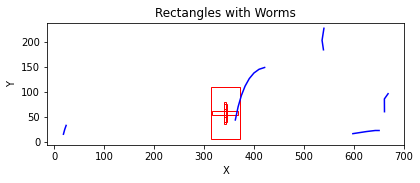

In [1339]:
plot_rectangles_with_worms(rectangle_clew, all_worm_points)

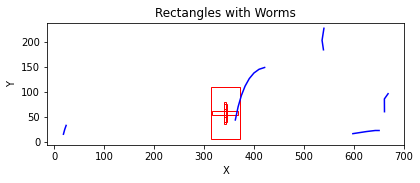

In [1340]:
plot_rectangles_with_worms(new_rectangles, all_worm_points)